## 1. Init

### Imports

In [1]:
import torch
import argparse
from pi3.utils.basic import load_images_as_tensor, write_ply
from pi3.utils.geometry import depth_edge
from pi3.models.pi3 import Pi3
from dataclasses import dataclass
from modules.dataloader import MTMCTrackingDataset, Pi3Transform

Warning, cannot find cuda-compiled version of RoPE2D, using a slow pytorch version instead


### Prepare

In [ ]:
@dataclass
class Args:
    data_path: str = './data/MTMC_Tracking_2025' # Path to input image directory or a video file
    save_path: str = 'examples/result.ply' # Path to save the output .ply file
    interval: int = -1 # Interval to sample image. Default: 1 for images dir, 10 for video
    ckpt: str = './weights/pi3.safetensors' # Path to the model checkpoint file. Default: None
    device: str = 'cuda' # Device to run inference on ('cuda' or 'cpu'). Default: 'cuda'

In [3]:
# 1. Prepare model
device = torch.device(Args().device if torch.cuda.is_available() else 'cpu')
if Args.ckpt is not None:
    model = Pi3().to(device).eval()
    if Args.ckpt.endswith('.safetensors'):
        from safetensors.torch import load_file
        weight = load_file(Args.ckpt)
    else:
        weight = torch.load(Args.ckpt, map_location=device, weights_only=False)
    
    model.load_state_dict(weight)
else:
    model = Pi3.from_pretrained("yyfz233/Pi3").to(device).eval()

## 2. Data + Preprocessing

In [ ]:
dataset_train = MTMCTrackingDataset(data_root=Args.data_path, split='train', transform=Pi3Transform(pixel_limit=255000))

Found 15 scenes in train split
Loading annotations...
Initializing video cache for 15 scenes...


Loading scenes: 100%|██████████| 15/15 [00:00<00:00, 57.73it/s]


Building frame index...
Dataset initialized with 135000 frames


In [27]:
sample_data = dataset_train[0]
sample_data.keys()

dict_keys(['images', 'intrinsics', 'extrinsics', 'camera_ids', 'annotations', 'scene_id', 'frame_idx'])

In [34]:
sample_data['annotations']

[{'object type': 'Forklift',
  'object id': 57,
  '3d location': [2.589342578738723, 10.800000190734863, 1.0755656460918708],
  '3d bounding box scale': [1.2138061252130683,
   2.3133651216321027,
   2.154944661372646],
  '3d bounding box rotation': [0.0, 0.0, 1.5707963267948963],
  '2d bounding box visible': {'Camera_0000': [1910, 463, 1919, 512],
   'Camera_0001': [1540, 350, 1657, 461],
   'Camera_0003': [976, 243, 986, 251],
   'Camera_0004': [1619, 518, 1758, 637],
   'Camera_0014': [696, 233, 785, 322],
   'Camera_0021': [277, 290, 953, 942],
   'Camera_0023': [1680, 275, 1783, 380]}},
 {'object type': 'NovaCarter',
  'object id': 56,
  '3d location': [4.465180451705131, 6.589205292334494, 0.3147760547400943],
  '3d bounding box scale': [0.7070674896238994,
   0.47694253921568147,
   0.47831288725069904],
  '3d bounding box rotation': [-0.0015440801243492772,
   3.0489510440327933e-07,
   -1.5467532634299829e-06],
  '2d bounding box visible': {'Camera_0001': [1804, 447, 1831, 470

In [28]:
# 2. Prepare input data
# The load_images_as_tensor function will print the loading path
imgs = torch.stack(sample_data['images']).to(device)

In [29]:
imgs.shape

torch.Size([25, 3, 1078, 1918])

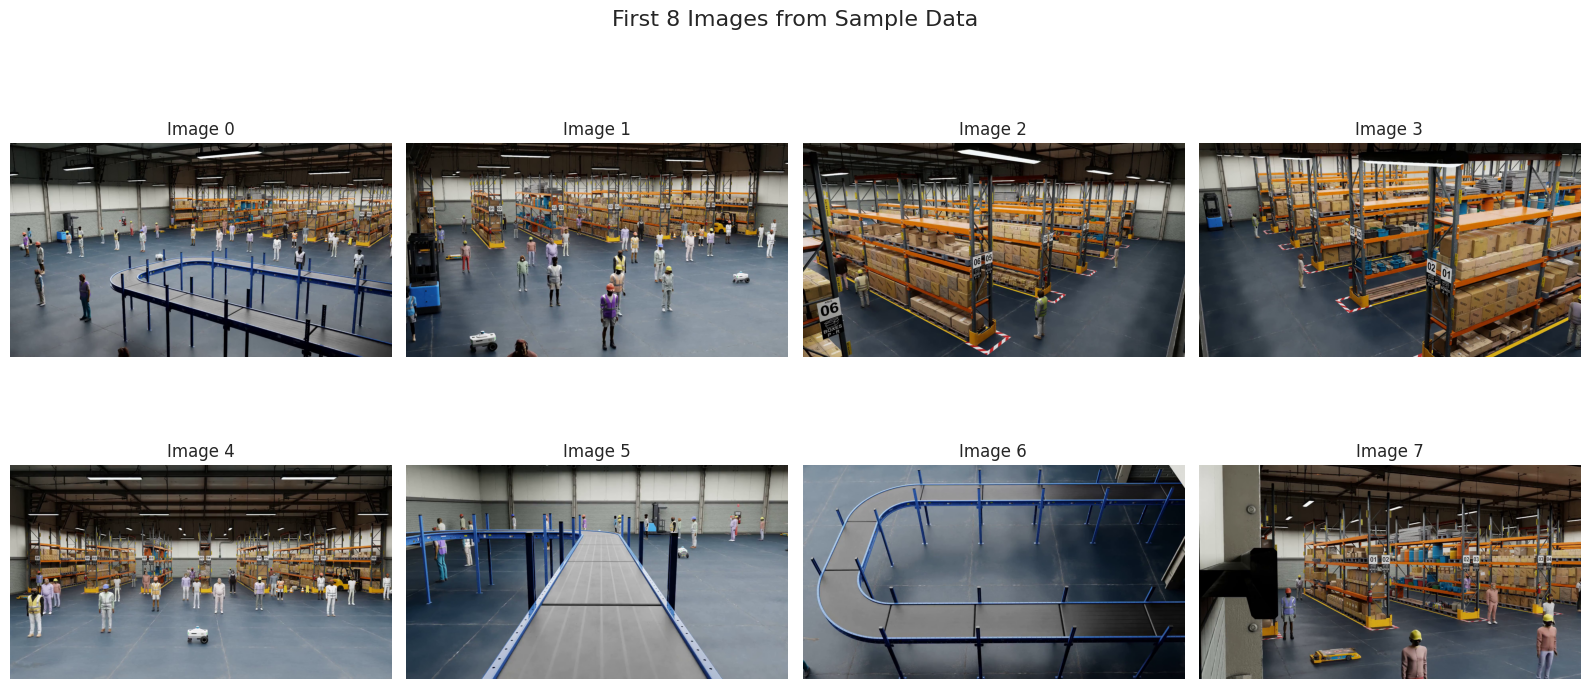

In [30]:
import seaborn as sns

import matplotlib.pyplot as plt

# Set up the plot style
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('First 8 Images from Sample Data', fontsize=16)

# Plot the first 8 images
for i in range(8):
    row = i // 4
    col = i % 4
    
    # Convert tensor to numpy and rearrange dimensions for matplotlib (H, W, C)
    img = sample_data['images'][i].permute(1, 2, 0).cpu().numpy()
    
    axes[row, col].imshow(img)
    axes[row, col].set_title(f'Image {i}')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

## 3. Inference

In [31]:
# 3. Infer
print("Running model inference...")
dtype = torch.bfloat16 if torch.cuda.get_device_capability()[0] >= 8 else torch.float16
with torch.no_grad():
    with torch.amp.autocast('cuda', dtype=dtype):
        res = model(imgs[None]) # Add batch dimension

Running model inference...


In [32]:
# 4. process mask
masks = torch.sigmoid(res['conf'][..., 0]) > 0.1
non_edge = ~depth_edge(res['local_points'][..., 2], rtol=0.03)
masks = torch.logical_and(masks, non_edge)[0]

In [33]:
# 5. Save points
print(f"Saving point cloud to: {Args.save_path}")
write_ply(res['points'][0][masks].cpu(), imgs.permute(0, 2, 3, 1)[masks], Args.save_path)
print("Done.")

Saving point cloud to: examples/result.ply
Done.
